In [1]:
cd ../src

/Users/phottovy/galvanize/04_Capstone_1/song_lyric_classifier/src


In [2]:
%matplotlib inline
import glob
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import nltk
# from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import itertools
import sys
import os.path
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from add_stop_words import add_stop_words, nltk_s_words
from tabulate import tabulate
from scipy import interp

In [3]:
plt.style.use('seaborn-darkgrid')
plt.rcParams["patch.force_edgecolor"] = True

In [4]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()
sksw = ENGLISH_STOP_WORDS
nltksw = nltk_s_words()
addsw = add_stop_words()

In [5]:
sw = sksw
lm = None
stm = None
mxf = None

In [6]:
# Create or import dataset
def get_data(artist='Bob Dylan', exact=False):
    '''
    Import or create a new a sample dataset
    '''
    location = '../data/'
    filename = artist.replace(' ', '_').lower()+'_sample_dataset_V2.csv'
    loc_file = location + filename
    if os.path.isfile(loc_file):
        df = pd.read_csv(loc_file)
    else:
        df = create_dataset(artist, exact, location, loc_file)
    return df

In [7]:
def create_dataset(artist, exact, location, loc_file):
    '''
    Creates a sample dataset of from the 500K song
    lyric dataset for the specified band/artist
    along with a random sample of songs for comparison data.

    Parameters
    ----------
    band: name of artist or band to be used in your analysis
    exact: boolean, default False
        Whether to filter by an exact match or a string that 
        contains the inputted artist/band value

    Returns
    -------
    .csv file containing all of the songs of the specified
    artist and a random sample (minimum 50 songs) of other
    songs from the dataset.
    '''
    full_dataset = location + 'every-song-you-have-heard-almost/Lyrics*.csv'
    full_dataset = pd.concat(
        [pd.read_csv(f) for f in glob.glob(full_dataset)])
    full_dataset.drop_duplicates(
        ['Band', 'Song', 'Lyrics'], inplace=True)
    if exact:
        artist_dataset = full_dataset[full_dataset['Band'].str.match(
            artist, case=False)].copy()
    else:
        artist_dataset = full_dataset[full_dataset['Band'].str.contains(
            artist, case=False)].copy()
    artist_dataset.drop_duplicates('Lyrics', inplace=True)
    rand_dataset = full_dataset[~full_dataset['Band'].str.match(
        artist, case=False)].sample(max(len(artist_dataset), 50))
    artist_dataset['Test_Artist'] = 1
    rand_dataset['Test_Artist'] = 0
    sample_dataset = pd.concat(
        [artist_dataset, rand_dataset]).copy()
    del full_dataset, artist_dataset, rand_dataset
    sample_dataset.to_csv(loc_file, index=False)
    return sample_dataset

In [8]:
def clean_full_dataset(dataset, stopwords=sksw, lemm=None, stem=None):
    '''
    Cleans the 'Lyrics' column from the master dataset.
    Returns a new dataframe and series containing the clean lyrics.
    '''
    clean_dataset = dataset.copy()
    clean_lyrics = clean_dataset['Lyrics']
    clean_lyrics = clean_strip_lyrics(clean_dataset['Lyrics'], stopwords, lemm, stem)
    
#     clean_dataset['Lyrics'] = clean_strip_lyrics(clean_dataset['Lyrics'], stopwords, lemm, stem)
#     print(clean_dataset)
    clean_dataset['Lyrics'] = clean_lyrics
#     print(clean_lyrics)
    return clean_dataset, clean_lyrics

In [9]:
def clean_strip_lyrics(dataset, stopwords=sksw, lemm=None, stem=None):
    '''
    Strip punctuation and cleans the word list

    Steps
    -----
    1. remove punctuation
    2. remove stopwords from provided dictionary, default sksw list
        'all' for a combination of three sets of stopwords
    3. stem word list, default None
    4. lemmatize word list, default None
    5. return list of clean word list from lyrics

    Parameters
    ----------
    lyrics: string of lyrics to be cleaned
    stopwords: dictionary of stopwords to exclude from model, default sksw from sklearn
    '''
#     if stopwords == 'all':
#         stopwords = combine_stopwords()
    rm_punct = [''.join(
        [char for char in word if char not in string.punctuation]) for word in dataset]
#     print(rm_punct[2])
    rm_stop = [[word.lower() for word in words.split()if word.lower()
                not in stopwords] for words in rm_punct]
#     print(rm_stop[2])
    if lemm == wordnet:
        rm_lemm = [[wordnet.lemmatize(word)
                    for word in words] for words in rm_stop]
    else:
        rm_lemm = rm_stop
#     print(rm_lemm[2])
    if stem == porter:
        rm_stem = [[porter.stem(word) for word in words] for words in rm_lemm]
    elif stem == snowball:
        rm_stem = [[snowball.stem(word) for word in words]
                   for words in rm_lemm]
    else:
        rm_stem = rm_lemm
#     print(rm_stem[2])
    clean_lyrics = [' '.join([word for word in words]) for words in rm_stem]
#     print(clean_lyrics[2])
#     print(pd.Series(clean_lyrics))
    return pd.Series(clean_lyrics)

In [10]:
def combine_stopwords():
    return set(list(sksw) + nltksw + addsw)

allsw = combine_stopwords

In [11]:
# pipeline for the model
def set_pipeline(X, y, max_feats=None):
    lyrics_pipeline = Pipeline([
        ('convert_lyrics', CountVectorizer(max_features=max_feats)),
        ('tf-idf', TfidfTransformer()),
        ('naive_bayes', MultinomialNB())
    ])
    return lyrics_pipeline.fit(X, y)

In [12]:
# split data between test and training data
def data_test_train_split(dataset, X_col='Lyrics', y_col='Test_Artist', size=0.3):
    '''
    Splits the dataset into training and test sets.
    '''
    X_train, X_test, y_train, y_test = train_test_split(
        dataset[X_col], dataset[y_col], test_size=size)
    return X_train, X_test, y_train, y_test

In [13]:
def make_predictions(pipeline, X_test):
    '''
    Makes predictions of y values based on the model.
    '''
    return pipeline.predict(X_test)

In [14]:
# Calculate Results
def print_classification_info(y_test, y_predict):
    cols = ['Statistic', 'Result']
    acc = ['Accuracy', '{:.4f}'.format(metrics.accuracy_score(y_test, y_predict))]   
    pre = ['Precision', '{:.4f}'.format(metrics.precision_score(y_test, y_predict))]
    rec = ['Recall', '{:.4f}'.format(metrics.recall_score(y_test, y_predict))]
    f1 = ['F1-Score', '{:.4f}'.format(metrics.f1_score(y_test, y_predict))]                                  
    print('Classification Statistics:\n')
    print(tabulate([cols, acc, pre, rec, f1], headers='firstrow', tablefmt='pipe'))       

In [15]:
def confuse_matrix(y_test, y_predict):
    '''
    Creates a confusion matrix. It flips the order of
    Sklearn's built in function.
    '''
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predict).ravel()
    cm_arr = np.array([[tp, fn], [fp, tn]])
    return cm_arr

In [84]:
def confusion_matrix_plot(y_test, y_predict, save_fig=False, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    '''
    cm = confuse_matrix(y_test, y_predict)
    classes = ['True', 'False']
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    if save_fig:
        plt.savefig('confusion_matrix.png')
    plt.show()

In [17]:
# create new dataset

new_dataset = get_data()
new_dataset.drop('Test_Artist', axis=1).describe()

,Band,Lyrics,Song
count,1234,1234,1234
unique,575,1230,1223
top,Bob Dylan,"Everything is set, skies are blue,\r\nCan't be...",Tears
freq,617,2,2


In [18]:
def roc_curve_plot(y_test, y_probs, save_fig=False):
    '''
    This function prints and plots the ROC plot.
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label='ROC curve', lw=2)
    plt.plot([0,1], [0,1], linestyle='--', lw=2, color='r')
    plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=14)
    plt.ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=14)
    plt.title("ROC plot", fontsize=20)
    plt.legend()
    if save_fig:
        plt.savefig('roc_plot.png')
    plt.show();

In [19]:
# create new dataset

new_dataset = get_data()
new_dataset.drop('Test_Artist', axis=1).describe()

,Band,Lyrics,Song
count,1234,1234,1234
unique,575,1230,1223
top,Bob Dylan,"Everything is set, skies are blue,\r\nCan't be...",Tears
freq,617,2,2


In [20]:
X_train, X_test, y_train, y_test = data_test_train_split(new_dataset)

In [21]:
train_df = pd.DataFrame()
train_df['Lyrics'] = X_train
train_df['Test_Artist'] = y_train
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,Lyrics,Test_Artist
0,If I was king\r\nI would rule the hands that y...,0
1,"Well, my shoes, they come from Singapore\nMy f...",1
2,Who's gonna throw that minstrel boy a coin?\r\...,1
3,We live in a political world\nLove don't have ...,1
4,It's just a good excuse to watch the sun go do...,0


In [22]:
test_df = pd.DataFrame()
test_df['Lyrics'] = X_test
test_df['Test_Artist'] = y_test
test_df.reset_index(drop=True, inplace=True)
test_df.head()

,Lyrics,Test_Artist
0,"Ah!\r\n\r\nRolling down the hill, snowballing ...",0
1,L'estate che scorre \r\nChe mi vengon' le vogl...,0
2,And all my sorrows awaken\r\nAnd all my fear's...,0
3,"Everything is set, skies are blue,\r\nCan't be...",0
4,Who's got a beard\r\nThat's long and white?\r\...,1


In [23]:
# original model parameters without CV
sw = sksw
lm = None
stm = None
mxf = None

clean_orig_train_df, clean_orig_train_lyrics = clean_full_dataset(train_df, stopwords=sw, lemm=lm, stem=lm)
clean_orig_test_df, clean_orig_test_lyrics = clean_full_dataset(test_df, stopwords=sw, lemm=lm, stem=lm)
orig_X_train, orig_y_train = clean_orig_train_df['Lyrics'], clean_orig_train_df['Test_Artist']
orig_X_test, orig_y_test = clean_orig_test_df['Lyrics'], clean_orig_test_df['Test_Artist']
orig_lyrics_pipeline = set_pipeline(orig_X_train, orig_y_train, max_feats=mxf)
orig_y_predictions = make_predictions(orig_lyrics_pipeline, orig_X_test)
orig_y_probs = orig_lyrics_pipeline.predict_proba(orig_X_test)[:,1]
print_classification_info(orig_y_test, orig_y_predictions)
confuse_matrix(orig_y_test, orig_y_predictions)
orig_fpr, orig_tpr, orig_thresholds = metrics.roc_curve(orig_y_test, orig_y_probs)
orig_auc = metrics.auc(orig_fpr, orig_tpr)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6631 |
| Precision   |   0.5966 |
| Recall      |   0.9558 |
| F1-Score    |   0.7346 |


In [24]:
# top metrics without cv
sw = sksw
lm = None
stm = None
mxf = 12000

clean_top_train_df, clean_top_train_lyrics = clean_full_dataset(train_df, stopwords=sw, lemm=lm, stem=lm)
clean_top_test_df, clean_top_test_lyrics = clean_full_dataset(test_df, stopwords=sw, lemm=lm, stem=lm)
top_X_train, top_y_train = clean_top_train_df['Lyrics'], clean_top_train_df['Test_Artist']
top_X_test, top_y_test = clean_top_test_df['Lyrics'], clean_top_test_df['Test_Artist']
top_lyrics_pipeline = set_pipeline(top_X_train, top_y_train, max_feats=mxf)
top_y_predictions = make_predictions(top_lyrics_pipeline, top_X_test)
top_y_probs = top_lyrics_pipeline.predict_proba(top_X_test)[:,1]
print_classification_info(top_y_test, top_y_predictions)
confuse_matrix(top_y_test, top_y_predictions)
top_fpr, top_tpr, top_thresholds = metrics.roc_curve(top_y_test, top_y_probs)
top_auc = metrics.auc(top_fpr, top_tpr)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6685 |
| Precision   |   0.6007 |
| Recall      |   0.9558 |
| F1-Score    |   0.7377 |


In [25]:
# bottom metrics
sw = addsw
lm = None
stm = snowball
mxf = 500

clean_bot_train_df, clean_bot_train_lyrics = clean_full_dataset(train_df, stopwords=sw, lemm=lm, stem=lm)
clean_bot_test_df, clean_bot_test_lyrics = clean_full_dataset(test_df, stopwords=sw, lemm=lm, stem=lm)
bot_X_train, bot_y_train = clean_bot_train_df['Lyrics'], clean_bot_train_df['Test_Artist']
bot_X_test, bot_y_test = clean_bot_test_df['Lyrics'], clean_bot_test_df['Test_Artist']
bot_lyrics_pipeline = set_pipeline(bot_X_train, bot_y_train, max_feats=mxf)
bot_y_predictions = make_predictions(bot_lyrics_pipeline, bot_X_test)
bot_y_probs = bot_lyrics_pipeline.predict_proba(bot_X_test)[:,1]
print_classification_info(bot_y_test, bot_y_predictions)
confuse_matrix(bot_y_test, bot_y_predictions)
bot_fpr, bot_tpr, bot_thresholds = metrics.roc_curve(bot_y_test, bot_y_probs)
bot_auc = metrics.auc(bot_fpr, bot_tpr)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.7143 |
| Precision   |   0.6667 |
| Recall      |   0.8287 |
| F1-Score    |   0.7389 |


In [26]:
# confusion_matrix_plot(orig_y_test, orig_y_predictions, save_fig=False)
# confusion_matrix_plot(top_y_test, top_y_predictions, save_fig=False)
# roc_curve_plot(orig_y_test, orig_y_probs, save_fig=False)
# roc_curve_plot(top_y_test, top_y_probs, save_fig=False)

In [27]:
# confusion_matrix_plot(orig_y_test, orig_y_predictions, save_fig=False)
# roc_curve_plot(orig_y_test, orig_y_probs, save_fig=False)

In [28]:
# confusion_matrix_plot(bot_y_test, bot_y_predictions, save_fig=False)
# roc_curve_plot(bot_y_test, bot_y_probs, save_fig=False)

# Gridsearch

In [29]:
def gridsearch_with_output(estimator, parameter_grid, X, y):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array

        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    refit=True,
                                    cv=4,
                                    scoring='f1')  # ['f1', 'precision', 'recall', 'accuracy'])
    model_gridsearch.fit(X, y)
    best_params = model_gridsearch.best_params_
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format(
        "Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param),
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best

In [30]:
def display_default_and_gsearch_model_results(model_default, model_gridsearch,
                                              X_test, y_test):
    '''
        Parameters: model_default: fit model using initial parameters
                    model_gridsearch: fit model using parameters from gridsearch
                    X_test: 2d numpy array
                    y_test: 1d numpy array
        Return: None, but prints out mse and r2 for the default and model with
                gridsearched parameters
    '''
    name = model_default.__class__.__name__.replace(
        'Regressor', '')  # for printing
    y_test_pred = model_gridsearch.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_test_pred)
    pre = metrics.precision_score(y_test, y_test_pred)
    rec = metrics.recall_score(y_test, y_test_pred)
    f1 = metrics.f1_score(y_test, y_test_pred)
#     print("Results for {0}".format(name))
    print("Gridsearched model acc: {:0.3f} | pre: {:0.3f} | rec = {:0.3f} | f1 = {:0.3f}".format(
        acc, pre, rec, f1))
    y_test_pred = model_default.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_test_pred)
    pre = metrics.precision_score(y_test, y_test_pred)
    rec = metrics.recall_score(y_test, y_test_pred)
    f1 = metrics.f1_score(y_test, y_test_pred)
    print("     Default model acc: {:0.3f} | pre: {:0.3f} | rec = {:0.3f} | f1 = {:0.3f}".format(
        acc, pre, rec, f1))

In [31]:
cv_pipeline = Pipeline([
    ('convert_lyrics', CountVectorizer()),
    ('tf-idf', TfidfTransformer()),
    ('naive_bayes', MultinomialNB())
])

In [32]:
# original paramters with CV
sw = sksw
lm = None
stm = None
mxf = None
feats_grid = {'convert_lyrics__max_features': [mxf]}

clean_dataset, clean_lyrics = clean_full_dataset(
    new_dataset, stopwords=sw, lemm=lm, stem=stm)
X = clean_dataset['Lyrics']
y = clean_dataset['Test_Artist']
orig_cv_best_params, orig_cv_best_model = gridsearch_with_output(cv_pipeline, 
                                                                 feats_grid, 
                                                                 X, y)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | None     | [None]


In [92]:
orig_cv_y_predict = orig_cv_best_model.predict(orig_X_test)
orig_cv_best_model.predict_proba(orig_X_train)[:, 1]
orig_cv_y_probs = orig_cv_best_model.predict_proba(orig_X_test)[:, 1]
orig_cv_fpr, orig_cv_tpr, t1 = metrics.roc_curve(orig_y_test, orig_cv_y_probs)
orig_cv_auc = metrics.auc(orig_cv_fpr, orig_cv_tpr)

In [34]:
# top paramters with CV
sw = sksw
lm = None
stm = None
mxf = 12000
feats_grid = {'convert_lyrics__max_features': [mxf]}

clean_dataset, clean_lyrics = clean_full_dataset(
    new_dataset, stopwords=sw, lemm=lm, stem=stm)
X = clean_dataset['Lyrics']
y = clean_dataset['Test_Artist']
top_cv_best_params, top_cv_best_model = gridsearch_with_output(cv_pipeline, 
                                                                 feats_grid, 
                                                                 X, y)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 12000    | [12000]


In [94]:
top_cv_y_predict = top_cv_best_model.predict(top_X_test)
top_cv_best_model.predict_proba(top_X_train)[:, 1]
top_cv_y_probs = top_cv_best_model.predict_proba(top_X_test)[:, 1]
top_cv_fpr, top_cv_tpr, t1 = metrics.roc_curve(top_y_test, top_cv_y_probs)
top_cv_auc = metrics.auc(top_cv_fpr, top_cv_tpr)

In [36]:
# bottom metrics with CV
sw = addsw
lm = None
stm = snowball
mxf = 500
feats_grid = {'convert_lyrics__max_features': [mxf]}

clean_dataset, clean_lyrics = clean_full_dataset(
    new_dataset, stopwords=sw, lemm=lm, stem=stm)
X = clean_dataset['Lyrics']
y = clean_dataset['Test_Artist']
bot_cv_best_params, bot_cv_best_model = gridsearch_with_output(cv_pipeline, 
                                                                 feats_grid, 
                                                                 X, y)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [500]


In [95]:
bot_cv_y_predict = bot_cv_best_model.predict(bot_X_test)
bot_cv_best_model.predict_proba(bot_X_train)[:, 1]
bot_cv_y_probs = bot_cv_best_model.predict_proba(bot_X_test)[:, 1]
bot_cv_fpr, bot_cv_tpr, t1 = metrics.roc_curve(bot_y_test, bot_cv_y_probs)
bot_cv_auc = metrics.auc(bot_cv_fpr, bot_cv_tpr)

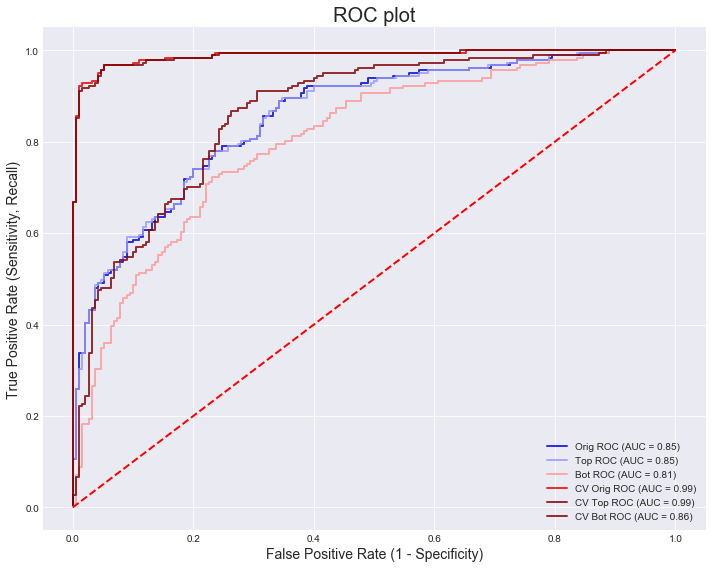

In [96]:
plt.figure(figsize=(10, 8))
palette = plt.get_cmap('seismic', lut=6)
plt.plot(orig_fpr, orig_tpr, label=f'Orig ROC (AUC = {orig_auc:.2f})', alpha=0.8, lw=2, color=palette(1))
plt.plot(top_fpr, top_tpr, label=f'Top ROC (AUC = {top_auc:.2f})', alpha=0.8, lw=2, color=palette(2))
plt.plot(bot_fpr, bot_tpr, label=f'Bot ROC (AUC = {bot_auc:.2f})', alpha=0.8, lw=2, color=palette(3))
plt.plot(orig_cv_fpr, orig_cv_tpr, label=f'CV Orig ROC (AUC = {orig_cv_auc:.2f})', alpha=0.8, lw=2, color=palette(4))
plt.plot(top_cv_fpr, top_cv_tpr, label=f'CV Top ROC (AUC = {top_cv_auc:.2f})', alpha=0.8, lw=2, color=palette(5))
plt.plot(bot_cv_fpr, bot_cv_tpr, label=f'CV Bot ROC (AUC = {bot_cv_auc:.2f})', alpha=0.8, lw=2, color=palette(6))
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='r')
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=14)
plt.ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=14)
plt.title("ROC plot", fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig('../images/cv_roc_plot.png')
plt.show();

In [109]:
def confusion_matrix_plot_grid(y_test, y_predict, name='', save_fig=False, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    '''
    plt.figure(figsize=(12, 4))
    # first plot
    cm1 = confuse_matrix(y_test[0], y_predict[0])
    plt.subplot(1, 3, 1)
    classes = ['True', 'False']
    plt.imshow(cm1, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix\nOriginal Parameters', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm1.max() / 2.
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        plt.text(j, i, format(cm1[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm1[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    
    # second plot
    cm2 = confuse_matrix(y_test[1], y_predict[1])
    plt.subplot(1, 3, 2)
    classes = ['True', 'False']
    plt.imshow(cm2, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix\nTop Parameters', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm2.max() / 2.
    for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
        plt.text(j, i, format(cm2[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm2[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    
    # third plot
    cm3 = confuse_matrix(y_test[2], y_predict[2])
    plt.subplot(1, 3, 3)
    classes = ['True', 'False']
    plt.imshow(cm3, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix\nBottom Parameters', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm3.max() / 2.
    for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
        plt.text(j, i, format(cm3[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm3[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'../images/{name}confusion_matrix.png')
    plt.show()

In [115]:
y_test_list = [orig_y_test, top_y_test, bot_y_test]
y_predict_list = [orig_y_predictions, top_y_predictions, bot_y_predictions]
y_cv_predict_list = [orig_cv_y_predict, top_cv_y_predict, bot_cv_y_predict]

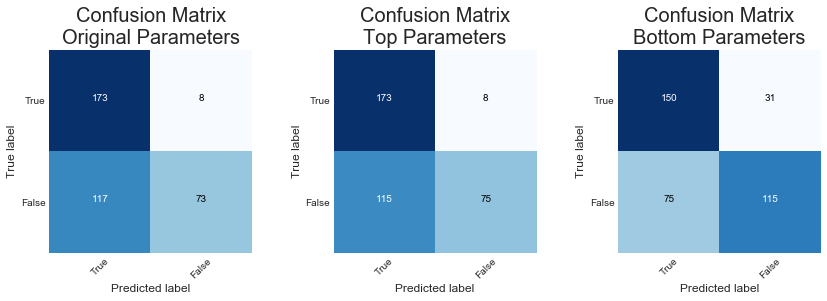

In [116]:
confusion_matrix_plot_grid(y_test_list, y_predict_list, save_fig=False)

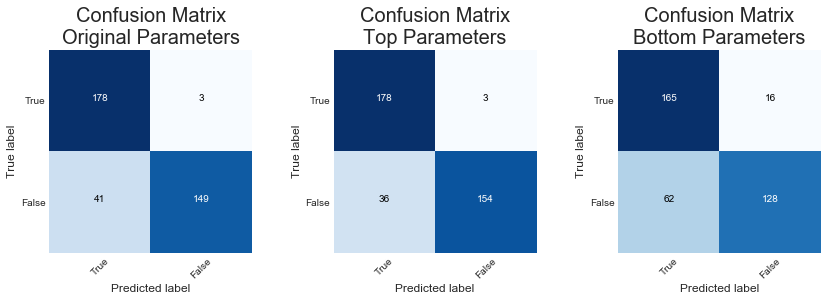

In [117]:
confusion_matrix_plot_grid(y_test_list, y_cv_predict_list, name='cv_', save_fig=False)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6631 |
| Precision   |   0.5966 |
| Recall      |   0.9558 |
| F1-Score    |   0.7346 |


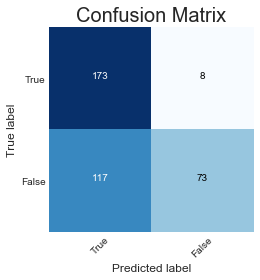

In [85]:
print_classification_info(orig_y_test, orig_y_predictions)
confusion_matrix_plot(orig_y_test, orig_y_predictions)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6685 |
| Precision   |   0.6007 |
| Recall      |   0.9558 |
| F1-Score    |   0.7377 |
[[173   8]
 [115  75]]


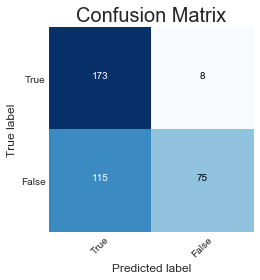

In [88]:
print_classification_info(top_y_test, top_y_predictions)
confusion_matrix_plot(top_y_test, top_y_predictions)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.7143 |
| Precision   |   0.6667 |
| Recall      |   0.8287 |
| F1-Score    |   0.7389 |


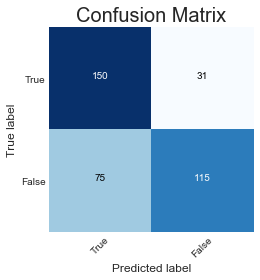

In [89]:
print_classification_info(bot_y_test, bot_y_predictions)
confusion_matrix_plot(bot_y_test, bot_y_predictions)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.8814 |
| Precision   |   0.8128 |
| Recall      |   0.9834 |
| F1-Score    |   0.89   |


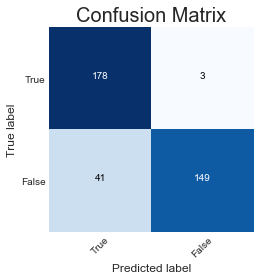

In [93]:
print_classification_info(orig_y_test, orig_cv_y_predict)
confusion_matrix_plot(orig_y_test, orig_cv_y_predict)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.8949 |
| Precision   |   0.8318 |
| Recall      |   0.9834 |
| F1-Score    |   0.9013 |


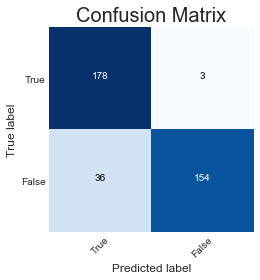

In [98]:
print_classification_info(top_y_test, top_cv_y_predict)
confusion_matrix_plot(top_y_test, top_cv_y_predict)

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.7898 |
| Precision   |   0.7269 |
| Recall      |   0.9116 |
| F1-Score    |   0.8088 |


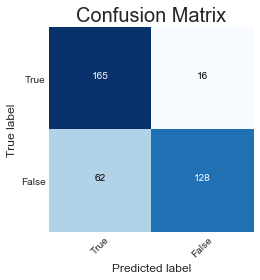

In [99]:
print_classification_info(bot_y_test, bot_cv_y_predict)
confusion_matrix_plot(bot_y_test, bot_cv_y_predict)

In [43]:
def confusion_matrix_plot_cv(tn, fp, fn, tp, save_fig=False, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    '''
    cm = np.array([[tp, fn], [fp, tn]])
    classes = ['True', 'False']
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    if save_fig:
        plt.savefig('confusion_matrix.png')
    plt.show()

In [44]:
def my_cross_val_score(dataset, num_folds=4, stopwords=sksw, lemm=None, stem=None, max_feats=None):
    ''' Returns error for k-fold cross validation. '''
#     print(stopwords)
    
    clean_dataset, clean_lyrics = clean_full_dataset(
        dataset, stopwords, lemm, stem)
    X = clean_dataset['Lyrics']
#     print(X)
    y = clean_dataset['Test_Artist']

    kf = KFold(n_splits=num_folds, shuffle=True)
    acc_cv = np.empty(num_folds)
    pre_cv = np.empty(num_folds)
    rec_cv = np.empty(num_folds)
    f1_cv = np.empty(num_folds)
    tn, fp, fn, tp = 0, 0, 0, 0
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    
    index = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lyrics_pipeline = set_pipeline(X_train, y_train, max_feats)
        y_predict = make_predictions(lyrics_pipeline, X_test)
        y_probs = lyrics_pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        acc_cv[index] = metrics.accuracy_score(y_test, y_predict)
        pre_cv[index] = metrics.precision_score(y_test, y_predict)
        rec_cv[index] = metrics.recall_score(y_test, y_predict)
        f1_cv[index] = metrics.f1_score(y_test, y_predict)
        tn += metrics.confusion_matrix(y_test, y_predict).ravel()[0]
        fp += metrics.confusion_matrix(y_test, y_predict).ravel()[1]
        fn += metrics.confusion_matrix(y_test, y_predict).ravel()[2]
        tp += metrics.confusion_matrix(y_test, y_predict).ravel()[3]
        index += 1  
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    cols = ['Statistic', 'Result']
    acc = ['Accuracy', '{:.4f}'.format(np.mean(acc_cv))]
    pre = ['Precision', '{:.4f}'.format(np.mean(pre_cv))]
    rec = ['Recall', '{:.4f}'.format(np.mean(rec_cv))]
    f1 = ['F1-Score', '{:.4f}'.format(np.mean(f1_cv))]
    print('Classification Statistics:\n')
    print(tabulate([cols, acc, pre, rec, f1],
                   headers='firstrow', tablefmt='pipe'))
    print(np.array([[tp, fn], [fp, tn]]))
#     confusion_matrix_plot_cv(tn, fp, fn, tp)
    return tn, fp, fn, tp, mean_fpr, mean_tpr, mean_auc, std_auc

In [45]:
# # original paramters with CV
# sw = sksw
# lm = None
# stm = None
# mxf = None

# def_tn, def_fp, def_fn, def_tp, def_mean_fpr, def_mean_tpr, def_mean_auc, def_std_auc = my_cross_val_score(new_dataset, stopwords=sw, lemm=lm, stem=stm, max_feats=mxf)

In [46]:
# # top paramters with CV
# sw = sksw
# lm = None
# stm = None
# mxf = 12000

# top_tn, top_fp, top_fn, top_tp, top_mean_fpr, top_mean_tpr, top_mean_auc, top_std_auc = my_cross_val_score(new_dataset, stopwords=sw, lemm=lm, stem=stm, max_feats=mxf)

In [47]:
# # bottom metrics with CV
# sw = addsw
# lm = None
# stm = snowball
# mxf = 500

# low_tn, low_fp, low_fn, low_tp, low_mean_fpr, low_mean_tpr, low_mean_auc, low_std_auc = my_cross_val_score(new_dataset, stopwords=sw, lemm=lm, stem=stm, max_feats=mxf)

In [48]:
# plt.figure(figsize=(10, 8))
# plt.plot(def_mean_fpr, def_mean_tpr, label=f'Def Mean ROC (AUC = {def_mean_auc:.2f} $\pm$ {def_std_auc:.2f})', alpha=0.5, lw=2)
# plt.plot(top_mean_fpr, top_mean_tpr, label=f'Top Mean ROC (AUC = {top_mean_auc:.2f} $\pm$ {top_std_auc:.2f})', alpha=0.5, lw=2)
# plt.plot(low_mean_fpr, low_mean_tpr, label=f'Low Mean ROC (AUC = {low_mean_auc:.2f} $\pm$ {low_std_auc:.2f})', alpha=0.5, lw=2)
# plt.plot(orig_fpr, orig_tpr, label=f'Orig ROC (AUC = {orig_auc:.2f})', alpha=0.5, lw=2)
# plt.plot(top_fpr, top_tpr, label=f'top ROC (AUC = {top_auc:.2f})', alpha=0.5, lw=2)
# plt.plot(bot_fpr, bot_tpr, label=f'bot ROC (AUC = {bot_auc:.2f})', alpha=0.5, lw=2)

# plt.plot([0,1], [0,1], linestyle='--', lw=2, color='r')
# plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=14)
# plt.ylabel("True Positive Rate (Sensitivity, Recall)", fontsize=14)
# plt.title("ROC plot", fontsize=20)
# plt.legend()
# ;